# DNN in TopFC analysis
Author: Meisam Ghasemi Bostanabad

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [2]:
import uproot
import numpy as np
import pandas as pd
import h5py
import awkward as ak
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar_trees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar_trees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar_trees/ZZ.root',
    'signal_up_TRR':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar_trees/signal_up_TRR.root'
    }


upfile = {}
params = {}
df = {}

# choose which vars to use (multi dimensional)
#VARS = ['jetNo','jetPTLeading','bjetPT','elecPTLeading','met','testnonTopMass', 'weight'] # choose which vars to use (2d)
VARS = ['jetNo','jetPTLeading', 'jetETA', 'jetPHI','bjetPT', 'bjetETA',
        'elecPTLeading', 'elecETA', 'elecPHI',
        'dielecCOS', 'dielecETA', 'met','testnonTopMass'] # choose which vars to use (2d)

# define trees and branches to make DataFrame
for treename in filename.keys():
    upfile[treename] = uproot.open(filename[treename])
    params[treename] = upfile[treename][treename].arrays(VARS)
    df[treename] = ak.to_dataframe(params[treename])
    # add isSignal variable
    if treename.startswith("signal"): 
        df[treename]['isSignal'] = np.ones(len(df[treename])) 
    else:
        df[treename]['isSignal'] = np.zeros(len(df[treename])) 

In [3]:
print(df['signal_up_TRR'].shape)
df['signal_up_TRR'].head()

(99913, 14)


jetNo  jetPTLeading    jetETA    jetPHI     bjetPT   bjetETA  \
entry subentry                                                                 
0     0             3     51.399311 -0.013246  1.587757  68.395027 -0.013246   
      1             3     51.399311  1.430854 -2.771022  68.395027 -0.013246   
      2             3     51.399311  1.414039 -0.196421  68.395027 -0.013246   
1     0             3    102.859726 -0.651368  1.355820  54.113873  1.436401   
      1             3    102.859726  1.092203 -0.383293  54.113873  1.436401   

                elecPTLeading   elecETA   elecPHI  dielecCOS  dielecETA  \
entry subentry                                                            
0     0             61.622402  0.735362  1.710677  -0.714178   0.852979   
      1             61.622402  1.588341 -0.655569  -0.714178   0.852979   
      2             61.622402  0.591618 -1.064715  -0.714178   0.852979   
1     0             71.335617 -0.118180 -2.223547  -0.048883  -1.319621   
      1             71.335617 -1.437800  2.439940  -0.048883  -1.319621   

                      met  testnonTopMass  isSignal  
entry subentry                                       
0     0         52.367043      155.873278       1.0  
      1         52.367043      155.873278       1.0  
      2         52.367043      155.873278       1.0  
1     0         19.808849      230.349964       1.0  
      1         19.808849      230.349964       1.0

In [4]:
df['signal_up_TRR'].iloc[38501]

jetNo               2.000000
jetPTLeading       88.932182
jetETA             -1.321828
jetPHI              2.517365
bjetPT             99.462334
bjetETA            -0.747839
elecPTLeading      79.869934
elecETA             0.172770
elecPHI             2.081770
dielecCOS          -0.966060
dielecETA           0.709066
met                75.585220
testnonTopMass    206.767902
isSignal            1.000000
Name: (15601, 1), dtype: float64

## Functions

In [5]:
# function to plot all distributions
def hist(df1, df2, cols, bins, ncols = 3):
    nrows = math.ceil(len(cols) / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 4.2 * nrows), sharey = False)
    for i in range(len(cols)):
        #sns.histplot(data = df, x = cols[i], bins = bins, hue = 'isSignal', palette = ['grey', 'red'], ax = ax[i // ncols, i % ncols], stat="probability")
        sns.histplot(data = df1, x = cols[i], bins = bins, color = 'red',
                      ax = ax[i // ncols, i % ncols], stat="density", label='bkg')
        sns.histplot(data = df2, x = cols[i], bins = bins, color = 'grey',
                      ax = ax[i // ncols, i % ncols], stat="density", label='sig')       
        ax[i // ncols, i % ncols].set_xlabel(cols[i])
        ax[i // ncols, i % ncols].legend()
        if i % ncols != 0:
            ax[i // ncols, i % ncols].set_ylabel(" ")
        
    plt.tight_layout()
    plt.show()


# function to make ML output and significant plot
samples =['ttbar', 'WZ', 'ZZ', 'signal_up_TRR']

def plot_SoverB(data, SoverB_hist_dict):
    
    signal = r'signal_up_TRR' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries
                #test=[]; test.append(df[s]['NN_output_prob'].values)


    
    
        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        mc_heights = distributions_axes.hist(mc_x, bins=bin_edges, color='red', 
                                             label='Total background',
                                             histtype='step', # lineplot that's unfilled
                                             density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='blue',
                                                 label=signal, 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        y_max = max(max(signal_heights[0]), max(mc_heights[0]) )
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        distributions_axes.set_ylim( top=y_max*1.2 ) # set y-axis limits
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
            
        plt.show() # show the Signal and background distributions
    
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            #signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            signal_weights_passing_cut = len(data[signal][data[signal][x_variable]>cut_value])
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    #background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
                    background_weights_passing_cut += len(data[s][data[s][x_variable]>cut_value])
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        #SoverB_axes.set_ylim( 100, 1000)
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label 
        
        plt.show() # show S/B plot
    
    return    

from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix

# function to draw loss-accuracy vs epoch and ROC curve
%matplotlib inline
def loss_accuracy_plotter(history):
    # plot loss vs epoch
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.legend(loc="upper right")
    ax.set_title('Loss over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # plot accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    ax.plot(history.history['accuracy'], label='acc')
    ax.plot(history.history['val_accuracy'], label='val_acc')
    ax.legend(loc="lower right")
    ax.set_title('Accuracy over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Plot ROC
    Y_predict = model.predict(X_test)
    Y_predict_train = model.predict(X_train_val)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('receiver operating curve')
    ax.legend(loc="lower right")
    plt.show()

# function to report all metrics evaluation
def evaluate(model, scaler, X, Y, X_train_val, Y_train_val, X_test, Y_test):
    Y_pred_test = model.predict(X_test)
    Y_pred_test = Y_pred_test.reshape(Y_pred_test.shape[0])
    Y_pred_train = model.predict(X_train_val)
    Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0])
    Y_pred_tot = model.predict(scaler.transform(X)).round()
    Y_pred_tot = Y_pred_tot.reshape(Y_pred_tot.shape[0])

    # accuracy score
    print("Test acc score:", accuracy_score(Y_test.round(), Y_pred_test.round()))
    print("Train acc score:", accuracy_score(Y_train_val.round(), Y_pred_train.round()))

    # classification report for the test and total sets
    print("Classification report for the test set")
    print(classification_report(Y_test.round(), Y_pred_test.round(), target_names=['background', 'signal']))
    print("Classification report for the total set")
    print(classification_report(Y.round(), Y_pred_tot.round(), target_names=['background', 'signal']))

    print("Confusion matrix for total set")
    print(confusion_matrix(Y.round(), Y_pred_tot.round()))

    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test) # get FPRs, TPRs and thresholds for neural network
    return fpr, tpr, thresholds

# plot AMS
def AMS(tpr, fpr, b_reg): # define function to calculate AMS
    return np.sqrt(2*((tpr+fpr+b_reg)*np.log(1+tpr/(fpr+b_reg))-tpr)) # equation for AMS

def cdf(sample, x, sort = False):
    '''
    Return the value of the Cumulative Distribution Function, evaluated for a given sample and a value x.
    
    Args:
        sample: The list or array of observations.
        x: The value for which the numerical cdf is evaluated.
    
    Returns:
        cdf = CDF_{sample}(x)
    '''
    
    # Sorts the sample, if needed
    if sort:
        sample.sort()
    
    # Counts how many observations are below x
    cdf = sum(sample <= x)
    
    # Divides by the total number of observations
    cdf = cdf / len(sample)
    
    return cdf

def ks_2samp_test(sample1, sample2):
    
    # Gets all observations
    observations = np.concatenate((sample1, sample2))
    observations.sort()
    
    # Sorts the samples
    sample1.sort()
    sample2.sort()
    
    # Evaluates the KS statistic
    D_ks = [] # KS Statistic list
    for x in observations:
        cdf_sample1 = cdf(sample = sample1, x  = x)
        cdf_sample2 = cdf(sample = sample2, x  = x)
        D_ks.append(abs(cdf_sample1 - cdf_sample2))
    ks_stat = max(D_ks)
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(len(sample1)), float(len(sample2))
    en = m * n / (m + n)
    p_value = stats.kstwo.sf(ks_stat, np.round(en))
    
    return {"ks_stat": ks_stat, "p_value" : p_value}

# plot train and test CLF distributions
def new_compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.predict(X[y<0.5]) # background
        d2 = clf.predict(X[y>0.5]) # signal
        decisions += [d1, d2] # add to list of classifier decision

    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)

    # Training plots
    plt.hist(decisions[0], # background in train set
            bins=bin_edges, # lower and upper range of the bins
            density=True, # area under the histogram will sum to 1
            histtype='stepfilled', # lineplot that's filled
            color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # signal in train set
            bins=bin_edges, # lower and upper range of the bins
            density=True, # area under the histogram will sum to 1
            histtype='stepfilled', # lineplot that's filled
            color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    # Testing plots
    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                            bins=bin_edges, # number of bins in function definition
                                            density=True ) # area under the histogram will sum to 1

    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres

    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                c='blue', label='Background (test)' ) # Background (test)

    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                        bins=bin_edges, # number of bins in function definition
                                        density=True ) # area under the histogram will sum to 1

    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background

    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='*', # circles
                c='orange', label='Signal (test)' ) # Signal (test)

    plt.xlabel(xlabel) # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
    ks_signal = ks_2samp_test(np.array(decisions[1]), np.array(decisions[3]))
    ks_background = ks_2samp_test(np.array(decisions[0]), np.array(decisions[2]))
    print(f"Signal: ks = {ks_signal['ks_stat']} (p-value = {ks_signal['p_value']}, are equal = {ks_signal['p_value'] > 0.05})")
    print(f"Background: ks = {ks_background['ks_stat']} (p-value = {ks_background['p_value']}, are equal = {ks_background['p_value'] > 0.05})")
    #return (decisions[0], decisions[2])
    

## Data exploration

In [6]:
# reduce signal DF size to have resonable Sig/Bkg ratio
df['signal_up_TRR'] = df['signal_up_TRR'][:20000]
df_all = pd.concat([df[treename] for treename in filename.keys()])

ttbar : (1181, 14)
WZ : (10855, 14)
ZZ : (174, 14)
signal_up_TRR : (20000, 14)
signal/tot bkg: 1.6


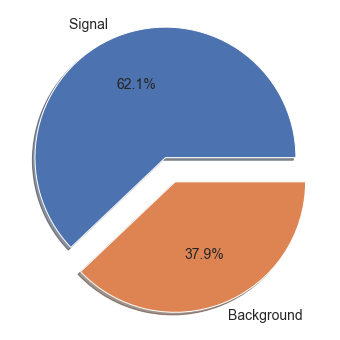

In [7]:
# number of entries in the backgrounds and signals
sns.set_theme(style="white")

tot_bkg = 0
for treename in filename.keys():
    if not 'signal' in treename: tot_bkg += df[treename].shape[0]
    print(treename, ":", df[treename].shape)

print("signal/tot bkg:", round((df['signal_up_TRR'].shape[0]/ tot_bkg),1))
#print("Null entries:", df['signal_charm'].isna().sum())

counts_signal = df['signal_up_TRR'].shape[0]
counts_background = tot_bkg

plt.figure(figsize=(8,6))
plt.pie([counts_signal, counts_background], explode=[0.1,0.1], shadow=True, labels=['Signal ','Background'], textprops={'fontsize': 14}, autopct='%1.1f%%');
#plt.pie([counts_signal, counts_background], explode=[0.1,0.1], shadow=True, labels=['Signal ','Background'], textprops={'color':"b"}, autopct='%1.1f%%');

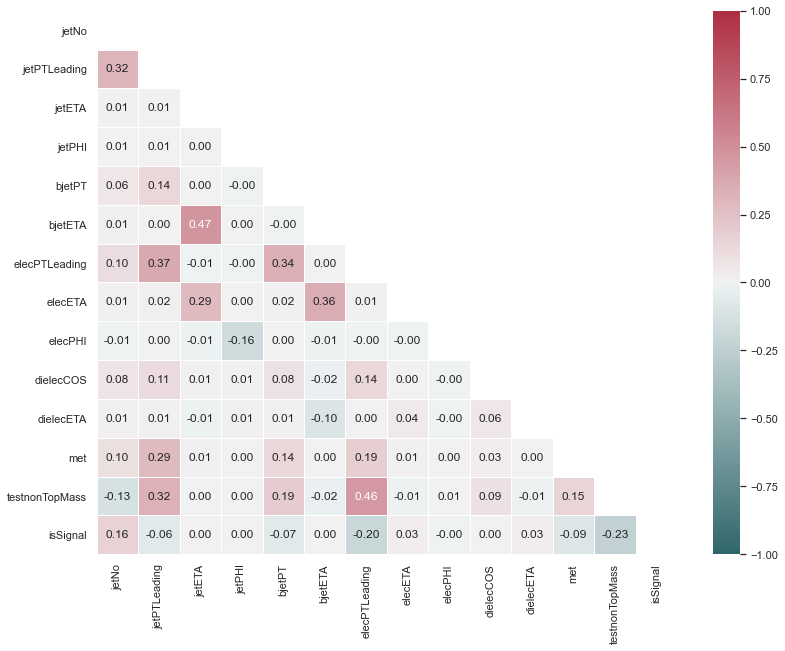

In [8]:
'''
# show the correlation between features
plt.figure(figsize=(10,8))
#sns.heatmap(df_all.corr(), annot=True, linewidth=.5)
sns.heatmap(df_all.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = plt.cm.CMRmap_r, fmt=".1f");
'''

plt.figure(figsize=(13,10))
#sns.set_theme(style="white")

# Getting the Upper Triangle of the co-relation matrix
corr = df_all.corr()
#matrix = np.triu(corr)
#mask = np.triu(np.ones_like(corr, dtype=bool))
matrix = np.triu(np.ones_like(corr))


cmap = sns.diverging_palette(200, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

#sns.heatmap(df_test.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = plt.cm.CMRmap_r, fmt=".1f", mask=matrix);
sns.heatmap(df_all.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = cmap, fmt=".2f", mask=matrix);

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 32210 entries, (0, 0) to (8124, 1)
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   jetNo           32210 non-null  int32  
 1   jetPTLeading    32210 non-null  float64
 2   jetETA          32210 non-null  float64
 3   jetPHI          32210 non-null  float64
 4   bjetPT          32210 non-null  float64
 5   bjetETA         32210 non-null  float64
 6   elecPTLeading   32210 non-null  float64
 7   elecETA         32210 non-null  float64
 8   elecPHI         32210 non-null  float64
 9   dielecCOS       32210 non-null  float64
 10  dielecETA       32210 non-null  float64
 11  met             32210 non-null  float64
 12  testnonTopMass  32210 non-null  float64
 13  isSignal        32210 non-null  float64
dtypes: float64(13), int32(1)
memory usage: 3.7 MB


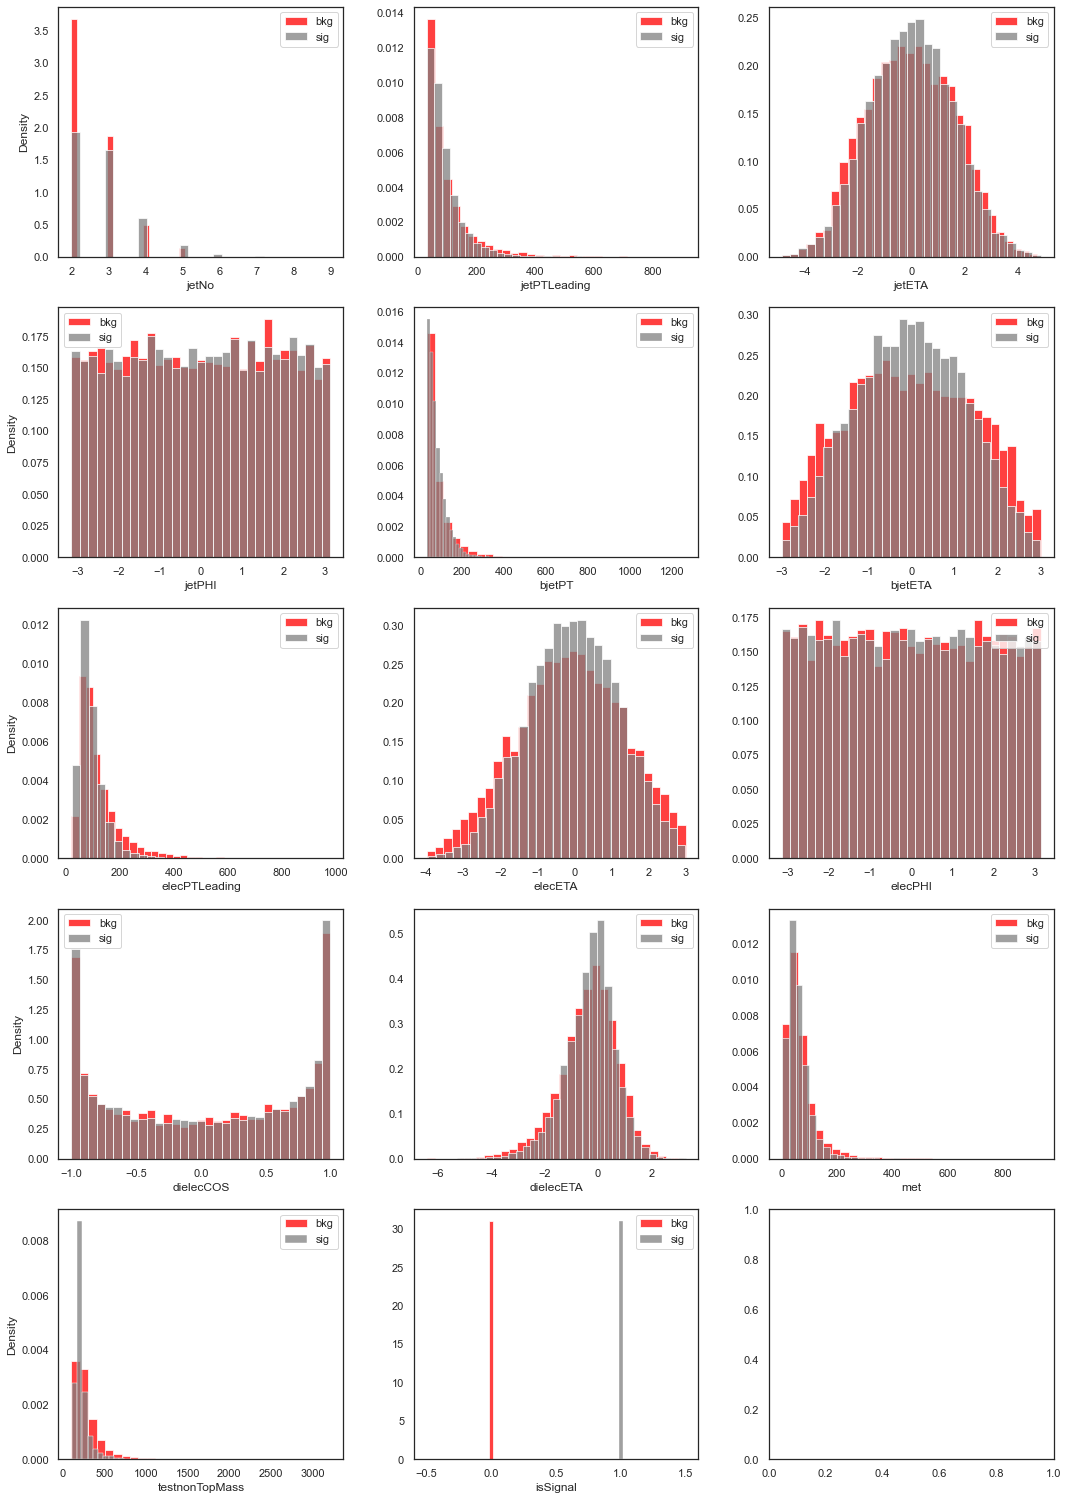

In [10]:
# Distributions of the float features
hist(df_all[df_all['isSignal']==0].replace(-999, np.nan),
     df_all[df_all['isSignal']==1].replace(-999, np.nan),
     #list(df_all.columns[df_all.dtypes == 'float64']),
     list(df_all.columns),
     bins = math.floor(len(df_all)**(1/3)),
     ncols = 3)

## Define the models

## simple NN from Tensorflow
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 
We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.

In [11]:
NDIM = len(VARS)
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# baseline keras model
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from tensorflow import keras

inputs = Input(shape=(NDIM,), name = 'input') 
hidden1 = Dense(20, name = 'hidden1', kernel_initializer='normal', activation='relu')(inputs)
hidden2 = Dense(20, name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden1)
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden2)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
optimizer = SGD(learning_rate=1e-3) # define the optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('tt_charm_NN_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 13)]              0         
                                                                 
 hidden1 (Dense)             (None, 20)                280       
                                                                 
 hidden2 (Dense)             (None, 20)                420       
                                                                 
 output (Dense)              (None, 1)                 21        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________


## Run training 
Here, we run the training.

In [12]:
# Train classifier
import time
start = time.time() # time at start of whole processing

history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=1000, 
                    batch_size=512, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Epoch 1/1000


51/51 [==============================] - 2s 10ms/step - loss: 0.6823 - accuracy: 0.6176 - val_loss: 0.6601 - val_accuracy: 0.6532
Epoch 2/1000
51/51 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6595 - val_loss: 0.6029 - val_accuracy: 0.6804
Epoch 3/1000
51/51 [==============================] - 0s 3ms/step - loss: 0.6009 - accuracy: 0.6789 - val_loss: 0.5887 - val_accuracy: 0.6964
Epoch 4/1000
51/51 [==============================] - 0s 2ms/step - loss: 0.5868 - accuracy: 0.6933 - val_loss: 0.5758 - val_accuracy: 0.7120
Epoch 5/1000
51/51 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.7088 - val_loss: 0.5624 - val_accuracy: 0.7197
Epoch 6/1000
51/51 [==============================] - 0s 6ms/step - loss: 0.5601 - accuracy: 0.7179 - val_loss: 0.5539 - val_accuracy: 0.7249
Epoch 7/1000
51/51 [==============================] - 0s 4ms/step - loss: 0.5529 - accuracy: 0.7224 - val_loss: 0.5492 - val_accuracy: 0.7282
Epoch 8/1000
51/51

## Plot performance and reports
Here, we plot the history of the training and the peNNormance in a ROC curve

806/806 [==============================] - 1s 1ms/step


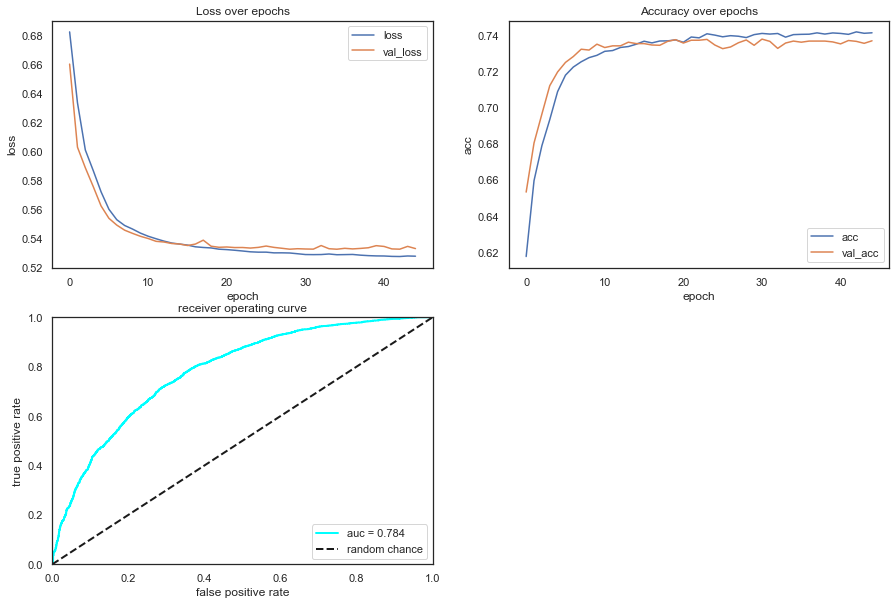

1007/1007 [==============================] - 1s 1ms/step
Test acc score: 0.7368829556038498
Train acc score: 0.7434802856255821
Classification report for the test set
              precision    recall  f1-score   support

  background       0.69      0.52      0.59      2384
      signal       0.75      0.87      0.81      4058

    accuracy                           0.74      6442
   macro avg       0.72      0.69      0.70      6442
weighted avg       0.73      0.74      0.73      6442

Classification report for the total set
              precision    recall  f1-score   support

  background       0.72      0.52      0.61     12210
      signal       0.75      0.88      0.81     20000

    accuracy                           0.74     32210
   macro avg       0.74      0.70      0.71     32210
weighted avg       0.74      0.74      0.73     32210

Confusion matrix for total set
[[ 6395  5815]
 [ 2490 17510]]
1007/1007 [==============================] - 1s 1ms/step


In [13]:
loss_accuracy_plotter(history)

fpr_nn, tpr_nn, thresholds_nn = evaluate(model, scaler, X, Y, X_train_val, Y_train_val, X_test, Y_test)
df_all['dense_NN'] = model.predict(scaler.transform(X)).round() # add prediction to array

1007/1007 [==============================] - 1s 1ms/step


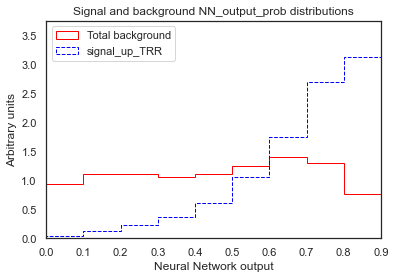

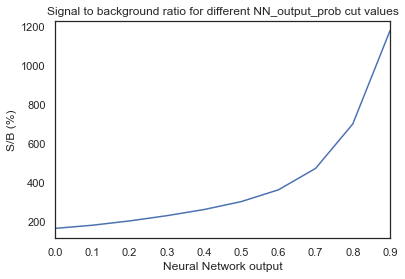

In [14]:
# add TF NN probability
y_tot_prob_NN = model.predict(scaler.transform(X))
y_tot_NN = model.predict(scaler.transform(X)).round()

cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['NN_output_prob'] = y_tot_prob_NN[cumulative_events:cumulative_events+len(df[key])]
    df[key]['NN_output'] = y_tot_NN[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events
    #print(df[key]['NN_output']) # print the dataframe column NN_output

# probability and significance plots
NN_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':9, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Neural Network output', # x-axis label
}

SoverB_hist_dict = {'NN_output_prob':NN_output_prob}
plot_SoverB(df, SoverB_hist_dict)

## NN Hyperparameter optimization

In [15]:
def main():
        
    keras_pipeline = Pipeline([("scaler", StandardScaler()),
                               ("clf", keras.wrappers.scikit_learn.KerasClassifier(
                                   build_fn=make_model))
    ])
    
    param_grid = {'clf__network_layers': [(32, 32), (64, 64), (128, 128, 128)],
     'clf__batch_size': [64, 128, 256, 512],
     'clf__epochs': [5, 10, 15, 50, 100, 200],
     'clf__dropout_rate': [0.1, 0.01],
     'clf__optimizer': ['Nadam', 'Adam', 'SGD'],
     'clf__activation': ['selu', 'relu', 'tanh'],
     'clf__k_initializer': ['lecun_normal', 'normal'],
     'clf__verbose': [0]
    }
    
    rs_keras = RandomizedSearchCV(keras_pipeline,
                                  param_distributions=param_grid,
                                  cv=5, refit=True,
                                  verbose=0,
                                  n_iter=5,
                                  scoring="accuracy")
    
    history = rs_keras.fit(np.array(X_train_val),
                 np.array(Y_train_val))
    
    print('Best score obtained: {0}'.format(rs_keras.best_score_))
    print('Parameters:')
    for param, value in rs_keras.best_params_.items():
        print('\t{}: {}'.format(param, value))
    return  rs_keras  

def make_model(network_layers=[(32, 32)],
               dropout_rate=0,
               optimizer="Nadam",
               activation="selu",
               k_initializer='lecun_normal',
               n_input=NDIM,
               n_class=1):
    
    model = keras.models.Sequential()

    for index, layers in enumerate(network_layers):
        if not index:
            model.add(keras.layers.Dense(layers,
                                         input_dim=n_input,
                                         activation=activation,
                                         kernel_initializer=k_initializer))
        else:
            model.add(keras.layers.Dense(layers,
                                         kernel_initializer=k_initializer,
                                         activation=activation))
        if dropout_rate and index:
            model.add(keras.layers.AlphaDropout(dropout_rate))

    model.add(keras.layers.Dense(n_class,
                                 activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    #print(model.summary())
    return model

NN_optimize = True
if NN_optimize:
    if __name__ == '__main__':
        opt_model = main()

<ipython-input-15-f8d0251f8942>:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ("clf", keras.wrappers.scikit_learn.KerasClassifier(


162/162 [==============================] - 0s 2ms/step
Best score obtained: 0.774022125143673
Parameters:
	clf__verbose: 0
	clf__optimizer: Nadam
	clf__network_layers: (128, 128, 128)
	clf__k_initializer: normal
	clf__epochs: 200
	clf__dropout_rate: 0.1
	clf__batch_size: 256
	clf__activation: selu


In [16]:
'''
Best score obtained: 0.774022125143673
Parameters:
	clf__verbose: 0
	clf__optimizer: Nadam
	clf__network_layers: (128, 128, 128)
	clf__k_initializer: normal
	clf__epochs: 200
	clf__dropout_rate: 0.1
	clf__batch_size: 256
	clf__activation: selu
'''

'\nBest score obtained: 0.774022125143673\nParameters:\n\tclf__verbose: 0\n\tclf__optimizer: Nadam\n\tclf__network_layers: (128, 128, 128)\n\tclf__k_initializer: normal\n\tclf__epochs: 200\n\tclf__dropout_rate: 0.1\n\tclf__batch_size: 256\n\tclf__activation: selu\n'

## NN with dropout layer for overfit checking

In [17]:
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

drop_model = models.Sequential()
drop_model.add(layers.Dense(128,  kernel_initializer='normal', activation='selu', input_shape=(NDIM,)))
drop_model.add(layers.Dropout(0.1))
drop_model.add(layers.Dense(128,  kernel_initializer='normal', activation='selu'))
drop_model.add(layers.Dropout(0.1))
drop_model.add(layers.Dense(128,  kernel_initializer='normal', activation='selu'))
drop_model.add(layers.Dropout(0.1))
drop_model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))

# compile the model
drop_model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
drop_model.summary()

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Train classifier
import time
start = time.time() # time at start of whole processing

drop_history = drop_model.fit(X_train_val,
                    Y_train_val,
                    epochs=200,
                    batch_size=256,
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping],
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 128)               1792      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_85 (Dense)            (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_86 (Dense)            (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_87 (Dense)            (None, 1)               

806/806 [==============================] - 1s 1ms/step


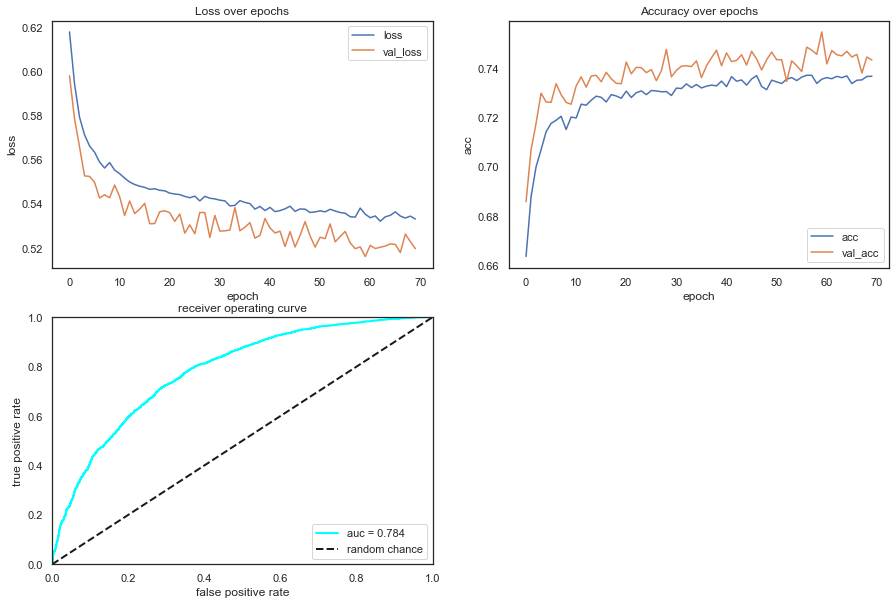

1007/1007 [==============================] - 2s 2ms/step
Test acc score: 0.7435579012728967
Train acc score: 0.7478655696988513
Classification report for the test set
              precision    recall  f1-score   support

  background       0.71      0.52      0.60      2384
      signal       0.76      0.88      0.81      4058

    accuracy                           0.74      6442
   macro avg       0.73      0.70      0.71      6442
weighted avg       0.74      0.74      0.73      6442

Classification report for the total set
              precision    recall  f1-score   support

  background       0.73      0.52      0.61     12210
      signal       0.75      0.88      0.81     20000

    accuracy                           0.75     32210
   macro avg       0.74      0.70      0.71     32210
weighted avg       0.74      0.75      0.74     32210

Confusion matrix for total set
[[ 6395  5815]
 [ 2334 17666]]
1007/1007 [==============================] - 1s 1ms/step


In [18]:
loss_accuracy_plotter(drop_history)

fpr_nn_opt_drop, tpr_nn_opt_drop, thresholds_nn_opt_drop = evaluate(drop_model, scaler, X, Y, X_train_val, Y_train_val, X_test, Y_test)
df_all['dense_NN_opt_drop'] = drop_model.predict(scaler.transform(X)).round() # add prediction to array

1007/1007 [==============================] - 2s 2ms/step


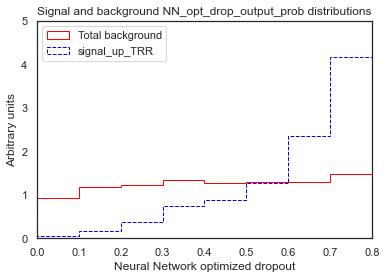

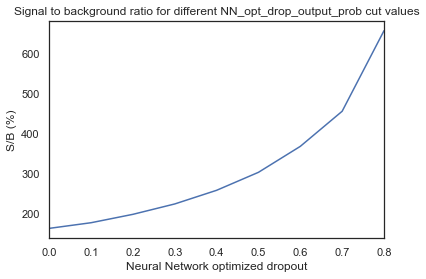

In [19]:
# add TF NN probability
y_tot_prob_NN_opt_drop = drop_model.predict(scaler.transform(X))
y_tot_NN_opt_drop = drop_model.predict(scaler.transform(X)).round()

cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['NN_opt_drop_output_prob'] = y_tot_prob_NN_opt_drop[cumulative_events:cumulative_events+len(df[key])]
    df[key]['NN_opt_drop_output'] = y_tot_NN_opt_drop[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events
    #print(df[key]['NN_output']) # print the dataframe column NN_output

# probability and significance plots
NN_opt_drop_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Neural Network optimized dropout', # x-axis label
}

SoverB_hist_dict = {'NN_opt_drop_output_prob':NN_opt_drop_output_prob}
plot_SoverB(df, SoverB_hist_dict)

## Optimal model with early stopping

In [20]:
inputs = Input(shape=(NDIM,), name = 'input') 
hidden1 = Dense(128, name = 'hidden1', kernel_initializer='lecun_normal', activation='selu')(inputs)
hidden2 = Dense(128, name = 'hidden2', kernel_initializer='lecun_normal', activation='selu')(hidden1)
hidden3 = Dense(128, name = 'hidden3', kernel_initializer='lecun_normal', activation='selu')(hidden2)
outputs = Dense(1, name = 'output', kernel_initializer='lecun_normal', activation='sigmoid')(hidden3)

# create the model
opt_model = Model(inputs=inputs, outputs=outputs)
# compile the model
opt_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
opt_model.summary()

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('TopFC_opt_dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True,                                    
                                   save_weights_only=False, mode='auto', 
                                   period=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 13)]              0         
                                                                 
 hidden1 (Dense)             (None, 128)               1792      
                                                                 
 hidden2 (Dense)             (None, 128)               16512     
                                                                 
 hidden3 (Dense)             (None, 128)               16512     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Train classifier
import time
start = time.time() # time at start of whole processing

opt_history = opt_model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=500, 
                    batch_size=256, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Epoch 1/500
101/101 [==============================] - 2s 7ms/step - loss: 0.5904 - accuracy: 0.6897 - val_loss: 0.5542 - val_accuracy: 0.7266
Epoch 2/500
101/101 [==============================] - 0s 4ms/step - loss: 0.5457 - accuracy: 0.7262 - val_loss: 0.5439 - val_accuracy: 0.7358
Epoch 3/500
101/101 [==============================] - 0s 5ms/step - loss: 0.5351 - accuracy: 0.7342 - val_loss: 0.5451 - val_accuracy: 0.7299
Epoch 4/500
101/101 [==============================] - 0s 4ms/step - loss: 0.5289 - accuracy: 0.7382 - val_loss: 0.5352 - val_accuracy: 0.7375
Epoch 5/500
101/101 [==============================] - 1s 6ms/step - loss: 0.5223 - accuracy: 0.7436 - val_loss: 0.5336 - val_accuracy: 0.7335
Epoch 6/500
101/101 [==============================] - 1s 5ms/step - loss: 0.5177 - accuracy: 0.7465 - val_loss: 0.5270 - val_accuracy: 0.7465
Epoch 7/500
101/101 [==============================] - 1s 7ms/step - loss: 0.5121 - accuracy: 0.7492 - val_loss: 0.5219 - val_accuracy: 0.7451

806/806 [==============================] - 1s 1ms/step


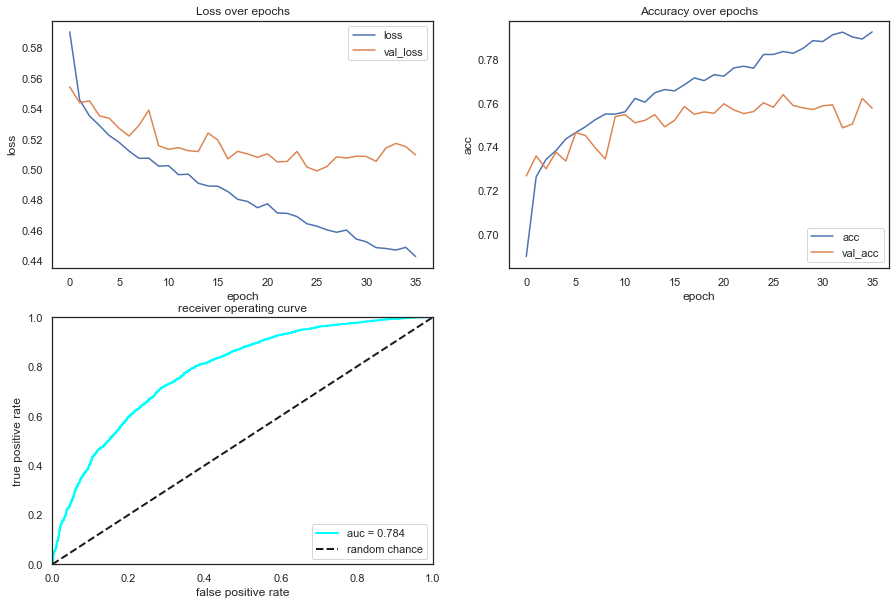

1007/1007 [==============================] - 1s 1ms/step
Test acc score: 0.7576839490841354
Train acc score: 0.7966858118596709
Classification report for the test set
              precision    recall  f1-score   support

  background       0.68      0.64      0.66      2384
      signal       0.80      0.83      0.81      4058

    accuracy                           0.76      6442
   macro avg       0.74      0.73      0.74      6442
weighted avg       0.76      0.76      0.76      6442

Classification report for the total set
              precision    recall  f1-score   support

  background       0.74      0.68      0.71     12210
      signal       0.81      0.85      0.83     20000

    accuracy                           0.79     32210
   macro avg       0.78      0.77      0.77     32210
weighted avg       0.79      0.79      0.79     32210

Confusion matrix for total set
[[ 8323  3887]
 [ 2913 17087]]
1007/1007 [==============================] - 1s 1ms/step


In [22]:
loss_accuracy_plotter(opt_history)

fpr_nn_opt, tpr_nn_opt, thresholds_nn_opt = evaluate(opt_model, scaler, X, Y, X_train_val, Y_train_val, X_test, Y_test)
df_all['dense_NN_opt'] = opt_model.predict(scaler.transform(X)).round() # add prediction to array

1007/1007 [==============================] - 1s 937us/step


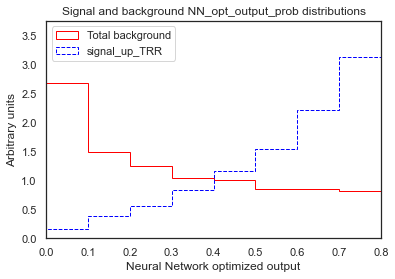

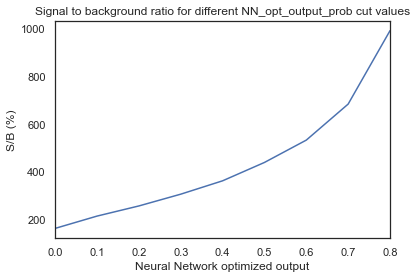

In [23]:
# add TF NN probability
y_tot_prob_NN_opt = opt_model.predict(scaler.transform(X))
y_tot_NN_opt = opt_model.predict(scaler.transform(X)).round()

cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['NN_opt_output_prob'] = y_tot_prob_NN_opt[cumulative_events:cumulative_events+len(df[key])]
    df[key]['NN_opt_output'] = y_tot_NN_opt[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events
    #print(df[key]['NN_output']) # print the dataframe column NN_output

# probability and significance plots
NN_opt_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Neural Network optimized output', # x-axis label
}

SoverB_hist_dict = {'NN_opt_output_prob':NN_opt_output_prob}
plot_SoverB(df, SoverB_hist_dict)

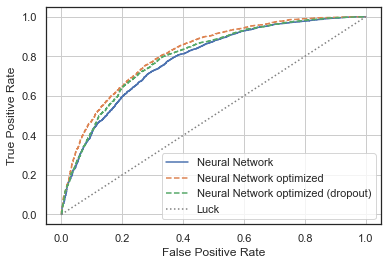

In [24]:
# plot ROC curve
plt.plot(fpr_nn, tpr_nn, label='Neural Network') # plot neural network ROC
plt.plot(fpr_nn_opt, tpr_nn_opt, linestyle='dashed', label='Neural Network optimized') # plot neural network optimized ROC
plt.plot(fpr_nn_opt_drop, tpr_nn_opt_drop, linestyle='dashed', label='Neural Network optimized (dropout)') # plot neural network optimized and dropout ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

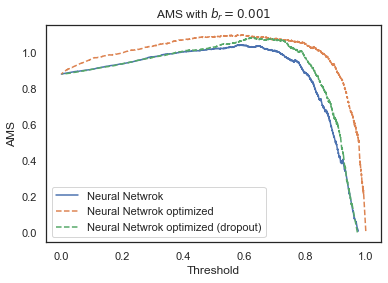

In [25]:
ams_nn = AMS(tpr_nn, fpr_nn, 0.001) # get AMS for NN classifier
ams_nn_opt = AMS(tpr_nn_opt, fpr_nn_opt, 0.001) # get AMS for NN-opt classifier
ams_nn_opt_drop = AMS(tpr_nn_opt_drop, fpr_nn_opt_drop, 0.001) # get AMS for NN-opt classifier


plt.plot(thresholds_nn, ams_nn, label="Neural Netwrok")  # plot NN AMS
plt.plot(thresholds_nn_opt, ams_nn_opt, linestyle='dashed', label="Neural Netwrok optimized")  # plot NN-opt AMS
plt.plot(thresholds_nn_opt_drop, ams_nn_opt_drop, linestyle='dashed', label="Neural Netwrok optimized (dropout)")  # plot NN-opt AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title("AMS with $b_r=0.001$")  # add plot title
plt.legend()  # add legend

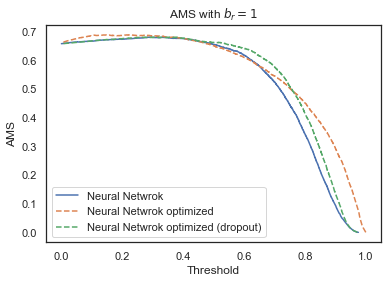

In [26]:
ams_nn = AMS(tpr_nn, fpr_nn, 1) # get AMS for NN classifier
ams_nn_opt = AMS(tpr_nn_opt, fpr_nn_opt, 1) # get AMS for NN-opt classifier
ams_nn_opt_drop = AMS(tpr_nn_opt_drop, fpr_nn_opt_drop, 1) # get AMS for NN-opt classifier


plt.plot(thresholds_nn, ams_nn, label="Neural Netwrok")  # plot NN AMS
plt.plot(thresholds_nn_opt, ams_nn_opt, linestyle='dashed', label="Neural Netwrok optimized")  # plot NN-opt AMS
plt.plot(thresholds_nn_opt_drop, ams_nn_opt_drop, linestyle='dashed', label="Neural Netwrok optimized (dropout)")  # plot NN-opt AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title("AMS with $b_r=1$")  # add plot title
plt.legend()  # add legend

## Overfit checking

In [ ]:
#new_compare_train_test(model, X_train_val, Y_train_val, X_test, Y_test, 'Neural Netwrok output')    

In [ ]:
#new_compare_train_test(opt_model, X_train_val, Y_train_val, X_test, Y_test, 'Neural Netwrok optimized output')

In [ ]:
#new_compare_train_test(drop_model, X_train_val, Y_train_val, X_test, Y_test, 'Neural Netwrok optimized dropoutoutput')

## Save all models

In [27]:
# simple NN
model.save('models/tt_up_TRR_NN.h5')

# NN optimized 
opt_model.save('models/tt_up_TRR_NN_opt.h5')


# NN optimized with drop
drop_model.save('models/tt_up_TRR_NN_drop.h5')

## Extend to the whole dataset

In [28]:
filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_up_TRR':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar_trees/signal_up_TRR.root'
    }

VARS = ['jetNo','jetPTLeading', 'jetETA', 'jetPHI','bjetPT', 'bjetETA',
        'elecPTLeading', 'elecETA', 'elecPHI',
        'dielecCOS', 'dielecETA', 'met','testnonTopMass', 'weight'] 

upfile = {}
params = {}
df = {}
NDIM = len(VARS)

# define trees and branches to make DataFrame
for treename in filename.keys():
    upfile[treename] = uproot.open(filename[treename])
    params[treename] = upfile[treename][treename].arrays(VARS)
    df[treename] = ak.to_dataframe(params[treename])
    # add isSignal variable
    if treename.startswith("signal"): 
        df[treename]['isSignal'] = np.ones(len(df[treename])) 
    else:
        df[treename]['isSignal'] = np.zeros(len(df[treename])) 
    tmp_dataset = df[treename].values
    X_tmp = tmp_dataset[:,0:NDIM-1]
    Y_tmp = tmp_dataset[:,NDIM]
    df[treename]['dense_NN'] = model.predict(scaler.transform(X_tmp)) # add prediction to array   
    df[treename]['dense_NN_opt'] = opt_model.predict(scaler.transform(X_tmp)) # add prediction to array
    df[treename]['dense_NN_opt_drop'] = drop_model.predict(scaler.transform(X_tmp)) # add prediction to array
    df[treename].to_csv("~/Desktop/IPM/Analysis/Dataframes/tt_up_TRR/"+treename+"_df.csv")
    

df_all = pd.concat([df[treename] for treename in filename.keys()])
dataset = df_all.values
X = dataset[:,0:NDIM-1]
Y = dataset[:,NDIM]

 1/37 [..............................] - ETA: 0s

3123/3123 [==============================] - 3s 795us/step


In [29]:
y_pred_NN_opt = opt_model.predict(X_test).round() # make predictions on the test data
y_pred_NN_train_opt = opt_model.predict(X_train_val).round()
y_pred_NN_tot_opt = opt_model.predict(scaler.transform(X)).round()

# See how well the classifier does, Acc = correct data / tot data
print("Total accuracy", accuracy_score(Y, y_pred_NN_tot_opt))

print("Classification report for the total set")
print(classification_report(Y.round(), y_pred_NN_tot_opt.round(), target_names=['background', 'signal']))

print("Confusion matrix:\n", confusion_matrix(Y.round(), y_pred_NN_tot_opt.round()))

fpr_nn_opt_tot, tpr_nn_opt_tot, thresholds_nn_opt_tot = roc_curve(Y, y_pred_NN_tot_opt.round()) # get FPRs, TPRs and thresholds for neural network

#df_all['dense_NN_opt'] = opt_model.predict(scaler.transform(X)).round() # add prediction to array
df_all['dense_NN_opt'] = opt_model.predict(scaler.transform(X)) # add prediction to array
df_all['dense_NN'] = model.predict(scaler.transform(X)) # add prediction to array

  1/202 [..............................] - ETA: 4s

3504/3504 [==============================] - 2s 700us/step
Total accuracy 0.7941546337504348
Classification report for the total set
              precision    recall  f1-score   support

  background       0.29      0.60      0.39     12210
      signal       0.94      0.82      0.88     99913

    accuracy                           0.79    112123
   macro avg       0.61      0.71      0.63    112123
weighted avg       0.87      0.79      0.82    112123

Confusion matrix:
 [[ 7267  4943]
 [18137 81776]]
3504/3504 [==============================] - 2s 684us/step


In [30]:
y_pred_NN_opt_fit = drop_model.predict(X_test).round() # make predictions on the test data
y_pred_NN_train_opt_fit = drop_model.predict(X_train_val).round()
y_pred_NN_tot_opt_fit = drop_model.predict(scaler.transform(X)).round()

# See how well the classifier does, Acc = correct data / tot data
print("Total accuracy", accuracy_score(Y, y_pred_NN_tot_opt_fit))

print("Classification report for the total set")
print(classification_report(Y.round(), y_pred_NN_tot_opt_fit.round(), target_names=['background', 'signal']))

print("Confusion matrix:\n", confusion_matrix(Y.round(), y_pred_NN_tot_opt_fit.round()))

fpr_nn_opt_tot_fit, tpr_nn_opt_tot_fit, thresholds_nn_opt_tot_fit = roc_curve(Y, y_pred_NN_tot_opt_fit.round()) # get FPRs, TPRs and thresholds for neural network

df_all['dense_NN_opt_drop'] = drop_model.predict(scaler.transform(X)) # add prediction to array

  1/202 [..............................] - ETA: 4s

3504/3504 [==============================] - 3s 708us/step
Total accuracy 0.8340839970389662
Classification report for the total set
              precision    recall  f1-score   support

  background       0.32      0.47      0.38     12210
      signal       0.93      0.88      0.90     99913

    accuracy                           0.83    112123
   macro avg       0.63      0.68      0.64    112123
weighted avg       0.87      0.83      0.85    112123

Confusion matrix:
 [[ 5783  6427]
 [12176 87737]]
3504/3504 [==============================] - 2s 700us/step


   1/3504 [..............................] - ETA: 1:18

3504/3504 [==============================] - 3s 750us/step


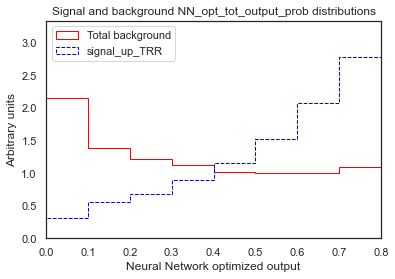

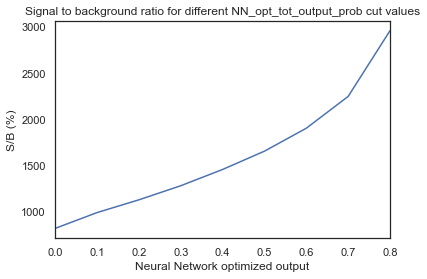

In [31]:
# add TF NN probability
y_TOT_prob_NN_opt = opt_model.predict(scaler.transform(X))
y_TOT_NN_opt = opt_model.predict(scaler.transform(X)).round()

cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['NN_opt_tot_output_prob'] = y_TOT_prob_NN_opt[cumulative_events:cumulative_events+len(df[key])]
    df[key]['NN_opt_tot_output'] = y_TOT_NN_opt[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events
    #print(df[key]['NN_output']) # print the dataframe column NN_output

# probability and significance plots
NN_opt_tot_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Neural Network optimized output', # x-axis label
}

SoverB_hist_dict = {'NN_opt_tot_output_prob':NN_opt_tot_output_prob}
plot_SoverB(df, SoverB_hist_dict)

   1/3504 [..............................] - ETA: 1:23

3504/3504 [==============================] - 3s 745us/step


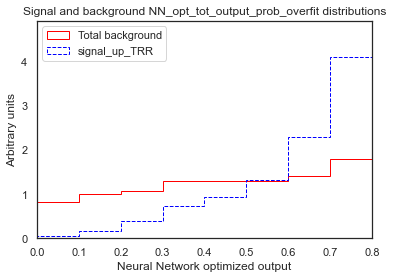

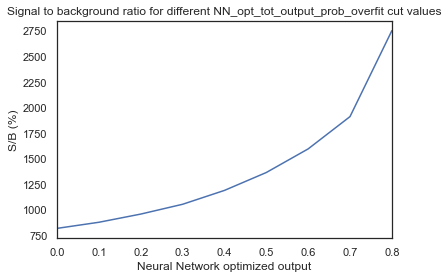

In [32]:
# add TF NN probability
y_TOT_prob_NN_opt_fit = drop_model.predict(scaler.transform(X))
y_TOT_NN_opt_fit = drop_model.predict(scaler.transform(X)).round()

cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['NN_opt_tot_output_prob_overfit'] = y_TOT_prob_NN_opt_fit[cumulative_events:cumulative_events+len(df[key])]
    df[key]['NN_opt_tot_output_overfit'] = y_TOT_NN_opt_fit[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events
    #print(df[key]['NN_output']) # print the dataframe column NN_output

# probability and significance plots
NN_opt_tot_output_prob_fit = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Neural Network optimized output', # x-axis label
}

SoverB_hist_dict = {'NN_opt_tot_output_prob_overfit':NN_opt_tot_output_prob_fit}
plot_SoverB(df, SoverB_hist_dict)

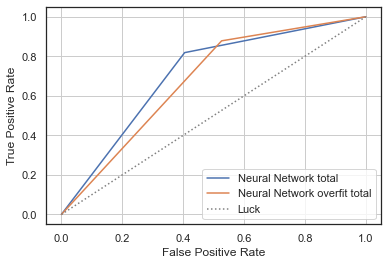

In [33]:
# plot ROC curve
plt.plot(fpr_nn_opt_tot, tpr_nn_opt_tot, label='Neural Network total') # plot Neural net-opt ROC
plt.plot(fpr_nn_opt_tot_fit, tpr_nn_opt_tot_fit, label='Neural Network overfit total') # plot Neural net-opt w overfit ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

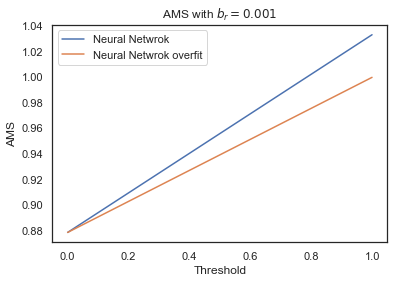

In [34]:
#ams_rf = AMS(tpr_rf, fpr_rf, 0.001) # get AMS for random forest classifier
ams_rf_opt_tot = AMS(tpr_nn_opt_tot, fpr_nn_opt_tot, 0.001) # get AMS for random forest classifier
ams_rf_opt_tot_fit = AMS(tpr_nn_opt_tot_fit, fpr_nn_opt_tot_fit, 0.001) # get AMS for random forest classifier

plt.plot(thresholds_nn_opt_tot, ams_rf_opt_tot, label="Neural Netwrok")  # plot Random forest AMS
plt.plot(thresholds_nn_opt_tot_fit, ams_rf_opt_tot_fit, label="Neural Netwrok overfit")  # plot Random forest AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title("AMS with $b_r=0.001$")  # add plot title
plt.legend()  # add legend

## Add prediction to `ROOT` trees and Excel
Here we'll add the precitions we've computed to `ROOT` trees and Excel format.

In [35]:
df_all.to_csv("~/Desktop/IPM/Analysis/Dataframes/tt_up_TRR/df_all.csv")

## Significance

In [36]:
df_all.head()

jetNo  jetPTLeading    jetETA    jetPHI      bjetPT   bjetETA  \
entry subentry                                                                  
0     0             2    181.824814 -1.844300 -1.531607  163.677521 -0.187704   
      1             2    181.824814 -0.187704  1.283405  163.677521 -0.187704   
1     0             3     67.292442  2.523575 -0.349919   32.879086  2.148290   
      1             3     67.292442 -0.431749  0.605245   32.879086  2.148290   
      2             3     67.292442  2.148290 -1.598545   32.879086  2.148290   

                elecPTLeading   elecETA   elecPHI  dielecCOS  dielecETA  \
entry subentry                                                            
0     0             88.220581 -1.844300 -1.531607  -0.952927   1.256450   
      1             88.220581 -0.187704  1.283405  -0.952927   1.256450   
1     0             87.680885  2.523575 -0.349919   0.520453  -1.629848   
      1             87.680885 -0.431749  0.605245   0.520453  -1.629848   
      2             87.680885  2.148290 -1.598545   0.520453  -1.629848   

                      met  testnonTopMass  weight  isSignal  dense_NN  \
entry subentry                                                          
0     0         63.312572      475.149068    0.74       0.0  0.466486   
      1         63.312572      475.149068    0.74       0.0  0.715113   
1     0         32.989780      206.483257    0.74       0.0  0.582994   
      1         32.989780      206.483257    0.74       0.0  0.539147   
      2         32.989780      206.483257    0.74       0.0  0.635186   

                dense_NN_opt  dense_NN_opt_drop  
entry subentry                                   
0     0             0.276915           0.194556  
      1             0.554346           0.350720  
1     0             0.075986           0.597275  
      1             0.152888           0.594216  
      2             0.101534           0.618270

In [37]:
df_all[df_all['isSignal']==0]['weight'].unique()

array([0.74, 0.03, 0.67])

### Cut-and-count analysis

In [38]:
sig_weight = df_all[df_all['isSignal']==1]['weight'].unique()[0]
df_sig_75 = df_all[(df_all['testnonTopMass']>=150) & (df_all['testnonTopMass']<=200) & (df_all['isSignal']==1)]
n_sig_75 = df_sig_75.shape[0] * sig_weight

bkg_weights = df_all[df_all['isSignal']==0]['weight'].unique()
list_bkg_75 = [df_all[(df_all['testnonTopMass']>=150) & (df_all['testnonTopMass']<=200) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]

print("75% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.1f}".format(n_sig_75, sum(list_bkg_75), n_sig_75/sum(list_bkg_75)))

75% : sig_n 534.6	bkg_n 503.1	sig/bkg 1.1


### Stats for simple NN

In [39]:
sig_weight = df_all[df_all['isSignal']==1]['weight'].unique()[0]
df_sig_75 = df_all[(df_all['dense_NN']>=0.7) & (df_all['isSignal']==1)]
n_sig_75 = df_sig_75.shape[0] * sig_weight
df_sig_80 = df_all[(df_all['dense_NN']>=0.75) & (df_all['isSignal']==1)]
n_sig_80 = df_sig_80.shape[0] * sig_weight
df_sig_85 = df_all[(df_all['dense_NN']>=0.8) & (df_all['isSignal']==1)]
n_sig_85 = df_sig_85.shape[0] * sig_weight

bkg_weights = df_all[df_all['isSignal']==0]['weight'].unique()
list_bkg_75 = [df_all[(df_all['dense_NN']>=0.7) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]
list_bkg_80 = [df_all[(df_all['dense_NN']>=0.75) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]
list_bkg_85 = [df_all[(df_all['dense_NN']>=0.8) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]

print("70% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.3f}".format(n_sig_75, sum(list_bkg_75), n_sig_75/sum(list_bkg_75)))
print("75% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.3f}".format(n_sig_80, sum(list_bkg_80), n_sig_75/sum(list_bkg_80)))
print("80% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.3f}".format(n_sig_85, sum(list_bkg_85), n_sig_75/sum(list_bkg_85)))

70% : sig_n 624.4	bkg_n 542.4	sig/bkg 1.151
75% : sig_n 511.8	bkg_n 420.3	sig/bkg 1.486
80% : sig_n 377.8	bkg_n 304.6	sig/bkg 2.050


### Stats for optimized NN

In [40]:
sig_weight = df_all[df_all['isSignal']==1]['weight'].unique()[0]
df_sig_75 = df_all[(df_all['dense_NN_opt']>=0.7) & (df_all['isSignal']==1)]
n_sig_75 = df_sig_75.shape[0] * sig_weight
df_sig_80 = df_all[(df_all['dense_NN_opt']>=0.75) & (df_all['isSignal']==1)]
n_sig_80 = df_sig_80.shape[0] * sig_weight
df_sig_85 = df_all[(df_all['dense_NN_opt']>=0.8) & (df_all['isSignal']==1)]
n_sig_85 = df_sig_85.shape[0] * sig_weight

bkg_weights = df_all[df_all['isSignal']==0]['weight'].unique()
list_bkg_75 = [df_all[(df_all['dense_NN_opt']>=0.7) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]
list_bkg_80 = [df_all[(df_all['dense_NN_opt']>=0.75) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]
list_bkg_85 = [df_all[(df_all['dense_NN_opt']>=0.8) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]

print("70% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.3f}".format(n_sig_75, sum(list_bkg_75), n_sig_75/sum(list_bkg_75)))
print("75% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.3f}".format(n_sig_80, sum(list_bkg_80), n_sig_75/sum(list_bkg_80)))
print("80% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.3f}".format(n_sig_85, sum(list_bkg_85), n_sig_75/sum(list_bkg_85)))

70% : sig_n 642.7	bkg_n 427.1	sig/bkg 1.505
75% : sig_n 577.6	bkg_n 349.4	sig/bkg 1.840
80% : sig_n 501.5	bkg_n 269.1	sig/bkg 2.389


### Stats for optimized NN with drop out layers

In [41]:
sig_weight = df_all[df_all['isSignal']==1]['weight'].unique()[0]
df_sig_75 = df_all[(df_all['dense_NN_opt_drop']>=0.7) & (df_all['isSignal']==1)]
n_sig_75 = df_sig_75.shape[0] * sig_weight
df_sig_80 = df_all[(df_all['dense_NN_opt_drop']>=0.75) & (df_all['isSignal']==1)]
n_sig_80 = df_sig_80.shape[0] * sig_weight
df_sig_85 = df_all[(df_all['dense_NN_opt_drop']>=0.8) & (df_all['isSignal']==1)]
n_sig_85 = df_sig_85.shape[0] * sig_weight

bkg_weights = df_all[df_all['isSignal']==0]['weight'].unique()
list_bkg_75 = [df_all[(df_all['dense_NN_opt_drop']>=0.7) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]
list_bkg_80 = [df_all[(df_all['dense_NN_opt_drop']>=0.75) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]
list_bkg_85 = [df_all[(df_all['dense_NN_opt_drop']>=0.8) & (df_all['isSignal']==0) & (df_all['weight'] == bkg_w)].shape[0] * bkg_w for bkg_w in bkg_weights]

print("70% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.3f}".format(n_sig_75, sum(list_bkg_75), n_sig_75/sum(list_bkg_75)))
print("75% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.3f}".format(n_sig_80, sum(list_bkg_80), n_sig_75/sum(list_bkg_80)))
print("80% : sig_n {:.1f}\tbkg_n {:.1f}\tsig/bkg {:.3f}".format(n_sig_85, sum(list_bkg_85), n_sig_75/sum(list_bkg_85)))

70% : sig_n 689.2	bkg_n 522.8	sig/bkg 1.318
75% : sig_n 590.9	bkg_n 417.7	sig/bkg 1.650
80% : sig_n 466.4	bkg_n 317.9	sig/bkg 2.168
